### Spatial Autocorrelation on Full FCC Data at CBG Level
  - Notable Changes
    - looking at the proportion of locations with fiber, instead of number of locations


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pysal.model as pm
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn
from splot.esda import plot_moran, lisa_cluster
import contextily as cx

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Users/kendall/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. Se

#### Step 1: Import Data

In [2]:
fcc_data = gpd.read_file("fcc_edited.geojson")

In [3]:
fcc_data = fcc_data.dropna()
len(fcc_data)

2171

In [4]:
fcc_data["fiber_prop"].mean()

np.float64(0.23425128347480884)

In [5]:
fcc_data.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
display(fcc_data.head())

,block_geoid,name,pop,pop_error,total_locations,locations_with_fiber,fiber_prop,geometry
0,170310101001,"BG 1, Tract 101, Cook, IL",461.0,245.0,65.0,0.0,0.0,"MULTIPOLYGON (((684020.489 2143481.837, 684079..."
1,170310101002,"BG 2, Tract 101, Cook, IL",1715.0,578.0,103.0,0.0,0.0,"MULTIPOLYGON (((683586.223 2143431.344, 683661..."
2,170310101003,"BG 3, Tract 101, Cook, IL",2108.0,473.0,106.0,0.0,0.0,"MULTIPOLYGON (((684249.008 2143127.653, 684239..."
3,170310102011,"BG 1, Tract 102.01, Cook, IL",2412.0,1090.0,158.0,0.0,0.0,"MULTIPOLYGON (((683098.419 2142513.680, 683115..."
4,170310102012,"BG 2, Tract 102.01, Cook, IL",1621.0,818.0,132.0,0.0,0.0,"MULTIPOLYGON (((683416.468 2142367.763, 683424..."


#### Step 2: Spatial Weights
 - Kernel weight -> kernel function (rate/shape of decay in weight as distance from focal point increases) and bandwidth (distance over which the kernel function is applied...larger distances have a weight of zero)
    - bandwidth is more influential according to Mora-Garcia et al., 2015
    - adaptive bandwidth (different bandwidth for each observation) -> necessary for cases in which the density of observations varies across the region of interest
      - explicitly incorporates Tobler's Law
      - costly operation (considers every pair of distances)
      - NOTE: try differernt bandwidth values to find ideal -- balance between creating disperse bumps that make pattern detection difficult and oversmoothing/obscuring variation of observations in the region (see conclusion of Mora-Garcia et al., 2015)
        - a bandwidth of 10 spatial units was reasonable in this paper. try bandwidths of 5, 10, 15, and 20 to see which autocorrelation results are the best
- Note: accounting for the curvature of the earth is not necessary at this scale

In [7]:
w_adapt = weights.distance.Kernel.from_dataframe(
    fcc_data, fixed=False, k=56, function="gaussian"
)

In [8]:
w_adapt.transform = "R"

#### Step 3: Spatial Lag Term
- allows for comparison between a spatial unit (block group) andd its neighbors (spatial lag is the average value of an observation among the neighbors of a focus region/unit)

In [9]:
fcc_data["prop_fiber_lag"] = weights.spatial_lag.lag_spatial(w_adapt, fcc_data["fiber_prop"])

#### Step 4: Global Autocorrelation

In [10]:
# Moran Plot -> variable of interest is displayed against its spatial lag
# see resource: https://lanselin.github.io/introbook_vol1/morans-i.html

## 1). Standardize variable of interest
fcc_data["prop_fiber_std"] = fcc_data["fiber_prop"] - fcc_data["fiber_prop"].mean()
fcc_data["prop_fiber_lag_std"] = weights.spatial_lag.lag_spatial(w_adapt, fcc_data["prop_fiber_std"])

In [11]:
display(fcc_data.sample(5))

,block_geoid,name,pop,pop_error,total_locations,locations_with_fiber,fiber_prop,geometry,prop_fiber_lag,prop_fiber_std,prop_fiber_lag_std
182,170310404022,"BG 2, Tract 404.02, Cook, IL",699.0,303.0,56.0,16.0,0.285714,"MULTIPOLYGON (((683471.214 2138086.342, 683492...",0.194314,0.051463,-0.039937
427,170311002007,"BG 7, Tract 1002, Cook, IL",901.0,340.0,270.0,238.0,0.881481,"MULTIPOLYGON (((673789.142 2139999.761, 673809...",0.624221,0.647230,0.389970
1504,170316114003,"BG 3, Tract 6114, Cook, IL",1904.0,1081.0,174.0,8.0,0.045977,"MULTIPOLYGON (((685890.887 2119552.189, 685895...",0.049530,-0.188274,-0.184721
43,170310203022,"BG 2, Tract 203.02, Cook, IL",1751.0,979.0,207.0,0.0,0.000000,"MULTIPOLYGON (((681908.556 2141254.491, 681907...",0.016254,-0.234251,-0.217997
851,170312415003,"BG 3, Tract 2415, Cook, IL",833.0,274.0,215.0,162.0,0.753488,"MULTIPOLYGON (((684714.517 2130903.042, 684735...",0.427179,0.519237,0.192927


In [12]:
# Calculate Moran's I statistic

glob_moran = esda.moran.Moran(fcc_data["fiber_prop"], w_adapt)
print(glob_moran.I) # -> 0.746; positive spatial autocorrelation
print(glob_moran.p_sim) # -> 0.001; statistically significant

0.615837950655541
0.001


m1: -0.0022816927225407548 m2: -1.963729348024229e-17


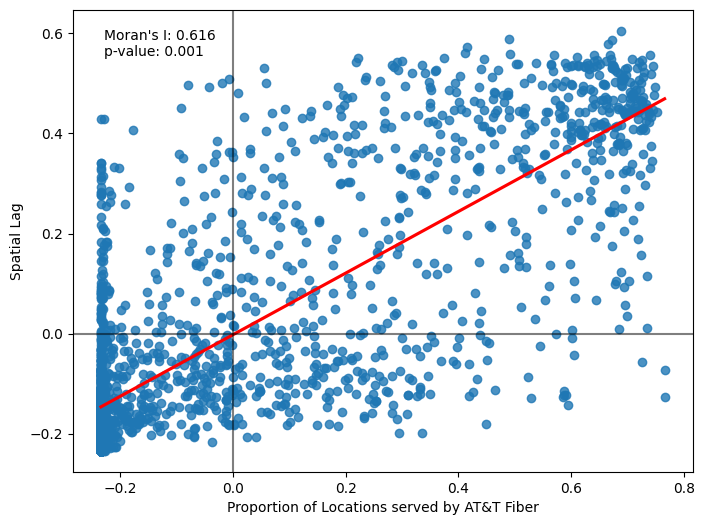

In [13]:
# see previous resource -> plot quadrants demarcated by ploting means of vertical and horizontal axes (both close to zero in this case)
m1 = fcc_data["prop_fiber_lag_std"].mean()
m2 = fcc_data["prop_fiber_std"].mean()
print("m1:", m1, "m2:", m2)

# # plotted vertical and horizontal lines at zeros
# # --> above average represented by standardized values greater than zero (see Local Spatial Autocorrelation chapter of https://geographicdata.science/book/notebooks/07_local_autocorrelation.html#getis-and-ord-s-local-statistics)

f, ax = plt.subplots(1, figsize=(8, 6))
seaborn.regplot(
    x="prop_fiber_std",
    y="prop_fiber_lag_std",
    ci=None,
    data=fcc_data,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5) #consider swapping 0 for m1 and m2, respectively
ax.axhline(0, c="k", alpha=0.5)
plt.xlabel('Proportion of Locations served by AT&T Fiber')
plt.ylabel('Spatial Lag')
plt.text(0.05, 0.9, f"Moran's I: {glob_moran.I:.3f}\np-value: {glob_moran.p_sim:.3f}", transform=plt.gca().transAxes)
#ax.set_title("Moran Plot - Proportion of Locations with FTTP Service")
plt.show()

In [14]:
#count the nmber of points in each quadrant
import numpy as np

def count_quadrants(x, y):
    q1 = np.sum((x > 0) & (y > 0))
    q2 = np.sum((x < 0) & (y > 0))
    q3 = np.sum((x < 0) & (y < 0))
    q4 = np.sum((x > 0) & (y < 0))
    return q1, q2, q3, q4

# Assuming 'x' is your prop_fiber_std and 'y' is prop_fiber_lag_std
q1, q2, q3, q4 = count_quadrants(fcc_data["prop_fiber_std"], fcc_data["prop_fiber_lag_std"])

print(f"Q1 (HH): {q1}, Q2 (LH): {q2}, Q3 (LL): {q3}, Q4 (HL): {q4}")

Q1 (HH): 559, Q2 (LH): 162, Q3 (LL): 1275, Q4 (HL): 175


#### Step 5: Local Autocorrelation
- goal: identify cases in which the value of an observation and the average if its surroundings is more similar (indicates cluster) or dissimilar (indicates outlier) that what we would expect under spatial randomness

In [15]:
loc_moran = esda.moran.Moran_Local(fcc_data["fiber_prop"], w_adapt)

<Axes: ylabel='Density'>

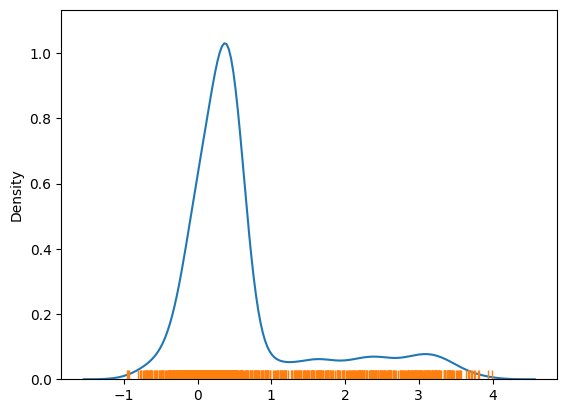

In [16]:
#plot distribution of local indicators

# Draw KDE line --> More info: https://seaborn.pydata.org/generated/seaborn.kdeplot.html
ax = seaborn.kdeplot(loc_moran.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(loc_moran.Is, ax=ax)

# clear skew towards positive autocorrelation/clustering of similar observations (x-axis represents local moran value for each observation)

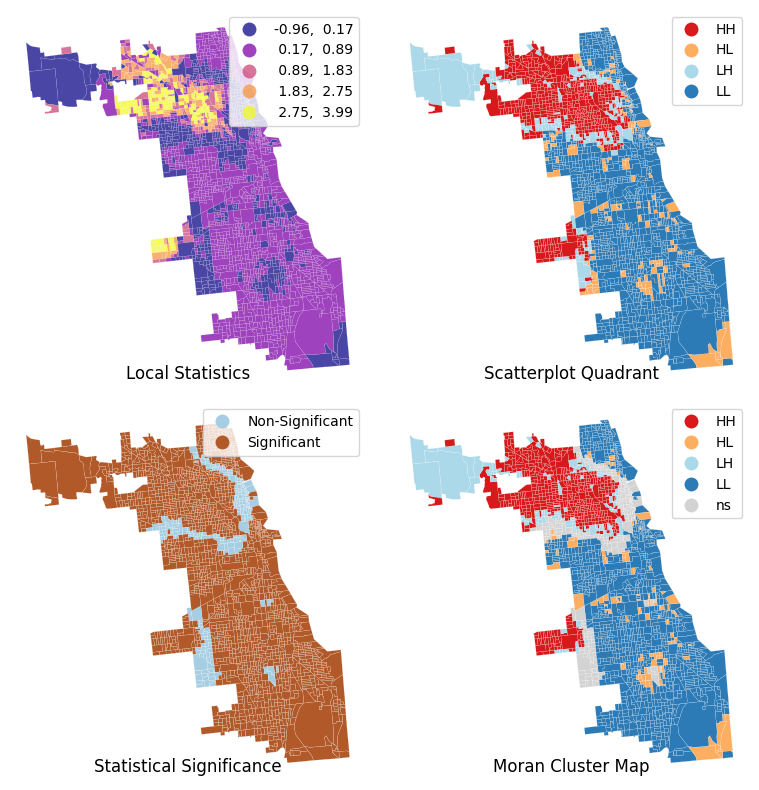

In [17]:
# Plot statistically significant clusters (High values with high values (HH), low values with low values (LL))
# or outliers (High-Low, Low-Hgh)
# Code adapted from : https://geographicdata.science/book/notebooks/07_local_autocorrelation.html#getis-and-ord-s-local-statistics

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]

# Assign new column with local statistics on-the-fly
fcc_data.assign(
    Is=loc_moran.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="natural_breaks", # more info on schemes: https://geopandas.org/en/stable/gallery/choropleths.html
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]

# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
lisa_cluster(loc_moran, fcc_data, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (loc_moran.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=fcc_data.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
fcc_data.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas -> narrowed down to significant/non significant classifications
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
lisa_cluster(loc_moran, fcc_data , p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [18]:
display(fcc_data)

,block_geoid,name,pop,pop_error,total_locations,locations_with_fiber,fiber_prop,geometry,prop_fiber_lag,prop_fiber_std,prop_fiber_lag_std
0,170310101001,"BG 1, Tract 101, Cook, IL",461.0,245.0,65.0,0.0,0.000000,"MULTIPOLYGON (((684020.489 2143481.837, 684079...",0.000150,-0.234251,-0.234101
1,170310101002,"BG 2, Tract 101, Cook, IL",1715.0,578.0,103.0,0.0,0.000000,"MULTIPOLYGON (((683586.223 2143431.344, 683661...",0.000156,-0.234251,-0.234096
2,170310101003,"BG 3, Tract 101, Cook, IL",2108.0,473.0,106.0,0.0,0.000000,"MULTIPOLYGON (((684249.008 2143127.653, 684239...",0.000146,-0.234251,-0.234105
3,170310102011,"BG 1, Tract 102.01, Cook, IL",2412.0,1090.0,158.0,0.0,0.000000,"MULTIPOLYGON (((683098.419 2142513.680, 683115...",0.000162,-0.234251,-0.234089
4,170310102012,"BG 2, Tract 102.01, Cook, IL",1621.0,818.0,132.0,0.0,0.000000,"MULTIPOLYGON (((683416.468 2142367.763, 683424...",0.000157,-0.234251,-0.234094
...,...,...,...,...,...,...,...,...,...,...,...
2168,170318447003,"BG 3, Tract 8447, Cook, IL",594.0,220.0,170.0,1.0,0.005882,"MULTIPOLYGON (((682502.405 2124619.391, 682597...",0.005559,-0.228369,-0.228692
2169,170319800001,"BG 1, Tract 9800, Cook, IL",0.0,12.0,40.0,2.0,0.050000,"MULTIPOLYGON (((662183.100 2139811.332, 662189...",0.526982,-0.184251,0.292731
2170,170319801001,"BG 1, Tract 9801, Cook, IL",0.0,12.0,4.0,1.0,0.250000,"MULTIPOLYGON (((678843.600 2117164.865, 678863...",0.514852,0.015749,0.280601
2171,170438400002,"BG 2, Tract 8400, DuPage, IL",1496.0,462.0,598.0,84.0,0.140468,"MULTIPOLYGON (((660778.312 2137891.651, 660759...",0.539723,-0.093783,0.305471


In [20]:
fcc_data2 = fcc_data.copy()
fcc_data2 = fcc_data2.assign(local_moran=loc_moran.Is)
fcc_data2=fcc_data2.assign(local_moran_p=loc_moran.p_sim)
fcc_data2=fcc_data2.assign(quadrant=loc_moran.q)

In [21]:
sig = fcc_data2[fcc_data2["local_moran_p"] < 0.05]

In [22]:
sig_q_counts = pd.value_counts(sig["quadrant"])
print(sig_q_counts)

quadrant
3    1159
1     516
4     121
2     115
Name: count, dtype: int64


/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_85298/1932867004.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sig_q_counts = pd.value_counts(sig["quadrant"])


In [23]:
# number of values in each quadrant (should add up to number of census block groups/observations)
# Q1 = HH, Q2 = LH, Q3 = LL, Q4 = HL



q_counts = pd.value_counts(loc_moran.q)
print(q_counts) 


# percentage of polygons/spatial units with significant local moran's I
percent_sig = (loc_moran.p_sim < 0.05).sum() * 100 / len(loc_moran.p_sim)
print(percent_sig) # about 65% of census blocks considered to be part of (or an outlier within) a spatial cluster

3    1275
1     559
4     175
2     162
Name: count, dtype: int64
88.02395209580838


/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_85298/2474961369.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  q_counts = pd.value_counts(loc_moran.q)
